# Urban Sound Classification

- http://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/

In [157]:
%matplotlib inline
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

## 音声のロードと可視化

In [158]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X, sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

In [159]:
def plot_waves(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=900)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        librosa.display.waveplot(np.array(f), sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot', x=0.5, y=0.915, fontsize=18)
    plt.show()

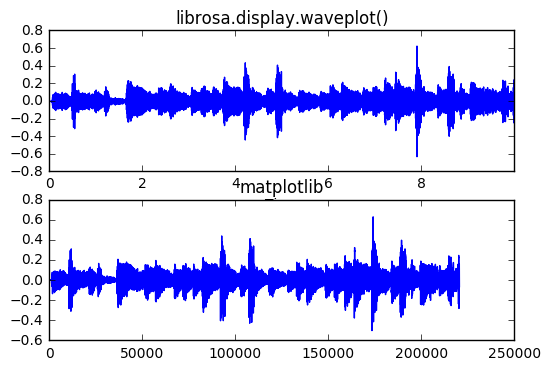

In [160]:
y, sr = librosa.load(librosa.util.example_audio_file(), duration=10)

plt.figure()
plt.subplot(2, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('librosa.display.waveplot()')

plt.subplot(2, 1, 2)
plt.plot(y)
plt.title('matplotlib')

In [161]:
def plot_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=900)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        specgram(np.array(f), Fs=22500)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram', x=0.5, y=0.915, fontsize=18)
    plt.show()

```
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music
```

In [164]:
sound_file_paths = ['../../git/urban-sound-classification-keras/data/UrbanSound8K/audio/fold1/101415-3-0-2.wav']
sound_names = ['dog_bark']

raw_sounds = load_sound_files(sound_file_paths)

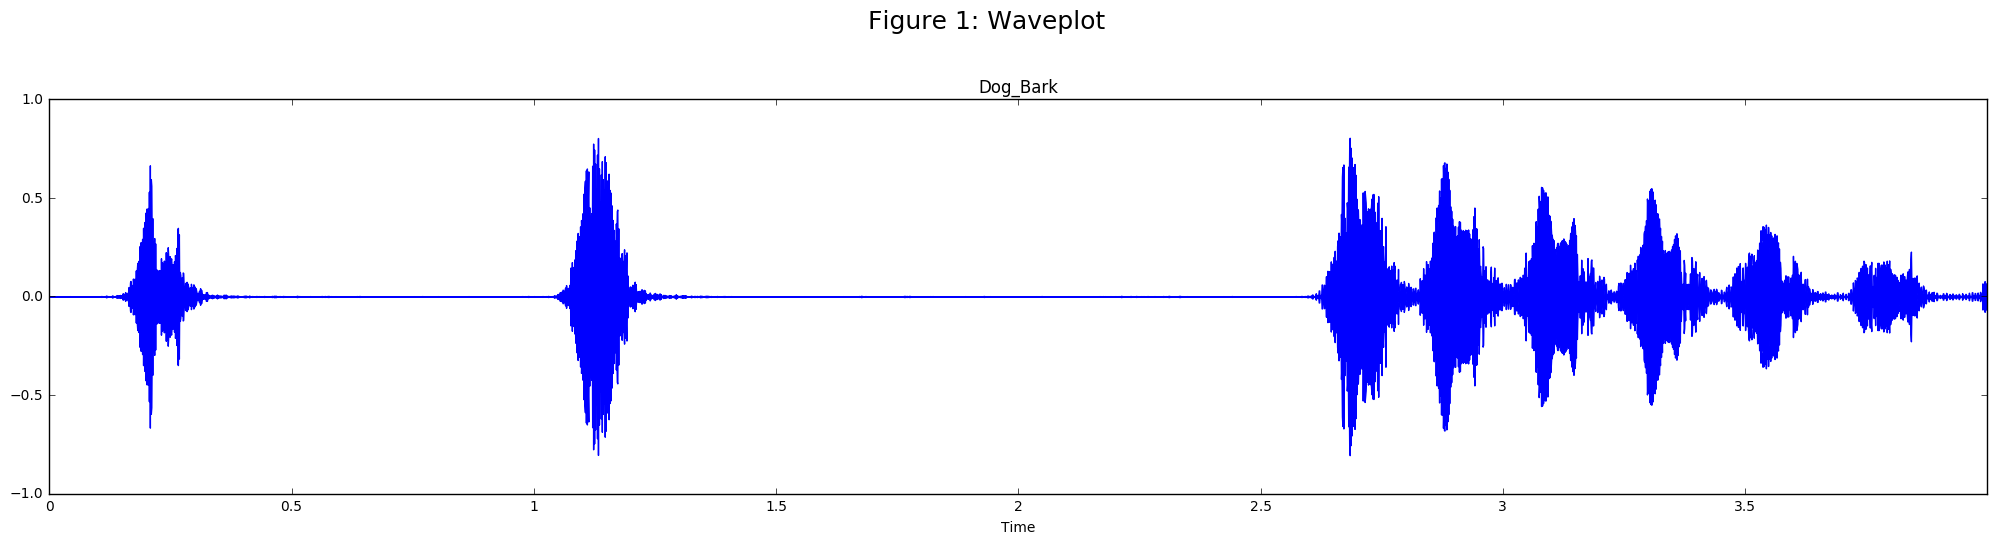

In [165]:
plot_waves(sound_names, raw_sounds)

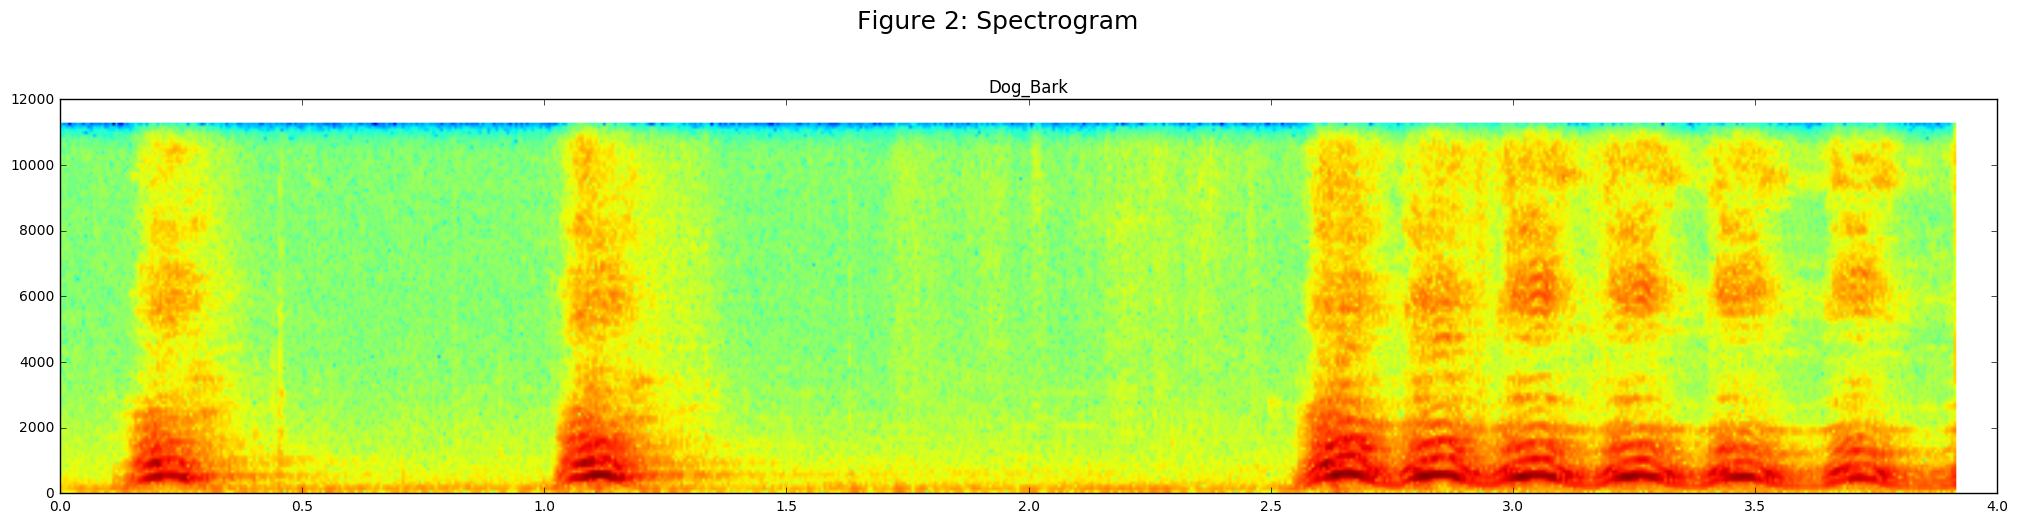

In [166]:
plot_specgram(sound_names, raw_sounds)

In [167]:
def plot_log_power_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=900)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        # パワースペクトログラムをdB単位（log）に変換
        D = librosa.logamplitude(np.abs(librosa.stft(f)) ** 2, ref_power=np.max)
        librosa.display.specshow(D, x_axis='time', y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram', x=0.5, y=0.915, fontsize=18)
    plt.show()

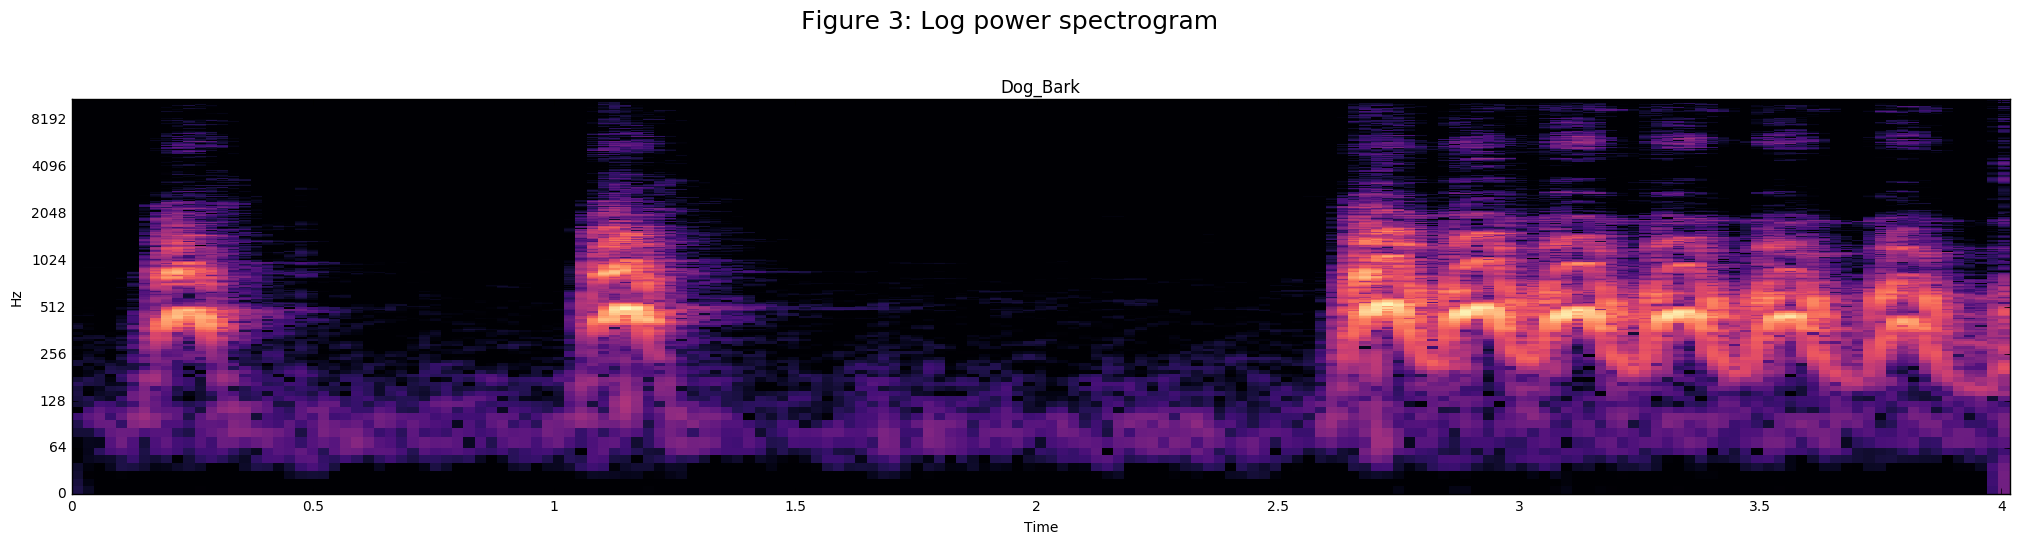

In [168]:
plot_log_power_specgram(sound_names, raw_sounds)

## 音響特徴量の抽出

- 各音声の時系列情報は無視して全時刻の特徴量の平均を計算する
- 1つの音声ファイルが193次元ベクトルで表される

In [169]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))

    # 特徴量は全フレームの平均を取る
    # 1つの音声ファイルが193次元ベクトルで表せる

    # MFCC 40次元
    # (40 features, 173 frame) => (40 features, )
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40), axis=1)

    # クロマグラム 12次元
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=1)

    # メルスペクトログラム 128次元
    # (128 features, 173 frame) => (128 features, )
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate), axis=1)

    # spectral contrast 7次元
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate), axis=1)
    
    # tonal centroid features 6次元
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate), axis=1)

    return mfccs, chroma, mel, contrast, tonnetz

In [176]:
def parse_audio_files(parent_dir, sub_dirs, file_ext='*.wav'):
    features, labels = np.empty((0, 193)), np.empty(0)
    for sub_dir in sub_dirs:
        print('***', sub_dir)
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                mfccs, chroma, mel, contrast, tonnetz = extract_feature(fn)
            except Exception as e:
                print('Error encountered while parsing file: ', fn)
                continue
            ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
            features = np.vstack([features, ext_features])
            # data/UrbanSound8K/audio/fold1/101415-3-0-2.wav => 3
            labels = np.append(labels, fn.split('/')[-1].split('-')[1])
    return np.array(features), np.array(labels, dtype=np.int)

In [177]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [175]:
parent_dir = '../data/UrbanSound8K/audio'
train_sub_dirs = ['fold1', 'fold2']
test_sub_dirs = ['fold3']

train_features, train_labels = parse_audio_files(parent_dir, train_sub_dirs)
test_features, test_labels = parse_audio_files(parent_dir, test_sub_dirs)

print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

*** fold1
*** fold2
*** fold3
(0, 193) (0,)
(0, 193) (0,)


## MLP

In [182]:
training_epochs = 50
n_dim = train_features.shape[1]
n_classes = 10
n_hidden_units_1 = 280
n_hidden_units_2 = 300
learning_rate = 0.01

193


In [186]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ModelCheckpoint

model = Sequential()
model.add(Dense(n_hidden_units_1, input_shape=(n_dim, )))
model.add(Activation('relu'))
model.add(Dense(n_hidden_units_2))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

In [184]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 280)               54320     
_________________________________________________________________
activation_4 (Activation)    (None, 280)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               84300     
_________________________________________________________________
activation_5 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                3010      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 141,630
Trainable params: 141,630
Non-trainable params: 0
_________________________________________________________________


In [187]:
logger = CSVLogger('train.log')
weight_file = 'train.{epoch:02d}-{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(weight_file,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')

In [188]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [189]:
model.fit(train_features, train_labels,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(test_features, test_labels),
          callbacks=[logger, checkpoint])

ValueError: Error when checking target: expected activation_9 to have shape (None, 10) but got array with shape (0, 0)